In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf
# from brokenaxes import brokenaxes
import itertools
from matplotlib.ticker import ScalarFormatter

%matplotlib inline

In [52]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    return R2

def CalcRMSE(observed, estimated):
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    return RMSE

In [53]:
df_original = pd.read_csv("/content/drive/MyDrive/UCL/Urban Simulation/Assessment/london_flows.csv")
df_original = df_original[df_original['station_origin'] != 'Battersea Park']
df_original = df_original[df_original['station_destination'] != 'Battersea Park']

print(len(df_original))
df_original = df_original[df_original["station_origin"] != df_original["station_destination"]]
print(len(df_original))

# add 1 to OD pairs with zero flows
df_original['flows'] = df_original['flows'].replace(0, 1)

61431
61413


In [54]:
print(f"There are {len(df_original['station_origin'].unique())} unique origins.")
print(f"There are {len(df_original['station_destination'].unique())} unique destinations.")

There are 398 unique origins.
There are 398 unique destinations.


In [55]:
dfmat = pd.pivot_table(df_original, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True) #, fill_value=0)
dfmat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,603
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1248
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,1.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,1.0,NaN,1.0,NaN,3797
Aldgate,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,17.0,...,1.0,NaN,4.0,8.0,NaN,1.0,NaN,1.0,NaN,3000
Aldgate East,NaN,NaN,2.0,1.0,NaN,NaN,1.0,1.0,NaN,20.0,...,24.0,1.0,1.0,12.0,NaN,1.0,NaN,1.0,NaN,3260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4893
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,543
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,1.0,NaN,NaN,59.0,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3122


In [56]:
# Log variables for future use
x_variables = ["population", "jobs", "distance"]
log_x_vars = []
for x in x_variables:
    df_original[f"log_{x}"] = np.log(df_original[x])
    log_x_vars.append(f"log_{x}")

# Exploratory Data Analysis

In [57]:
# Sort the DataFrame by 'flows' column in descending order and get the top 10 rows
top_flows = df_original.nlargest(10, 'flows')
top_flows[['flows', 'station_origin', 'station_destination']]

,flows,station_origin,station_destination
55949,15946,Waterloo,Bank and Monument
55974,8085,Waterloo,Canary Wharf
50095,6946,Stratford,Liverpool Street
32654,6165,London Bridge,Canary Wharf
54825,5181,Victoria,Oxford Circus
8542,4030,Canada Water,Canary Wharf
49948,3875,Stratford,Canary Wharf
32403,3755,Liverpool Street,Farringdon
18965,3659,Finsbury Park,Highbury & Islington
8662,3202,Canada Water,London Bridge


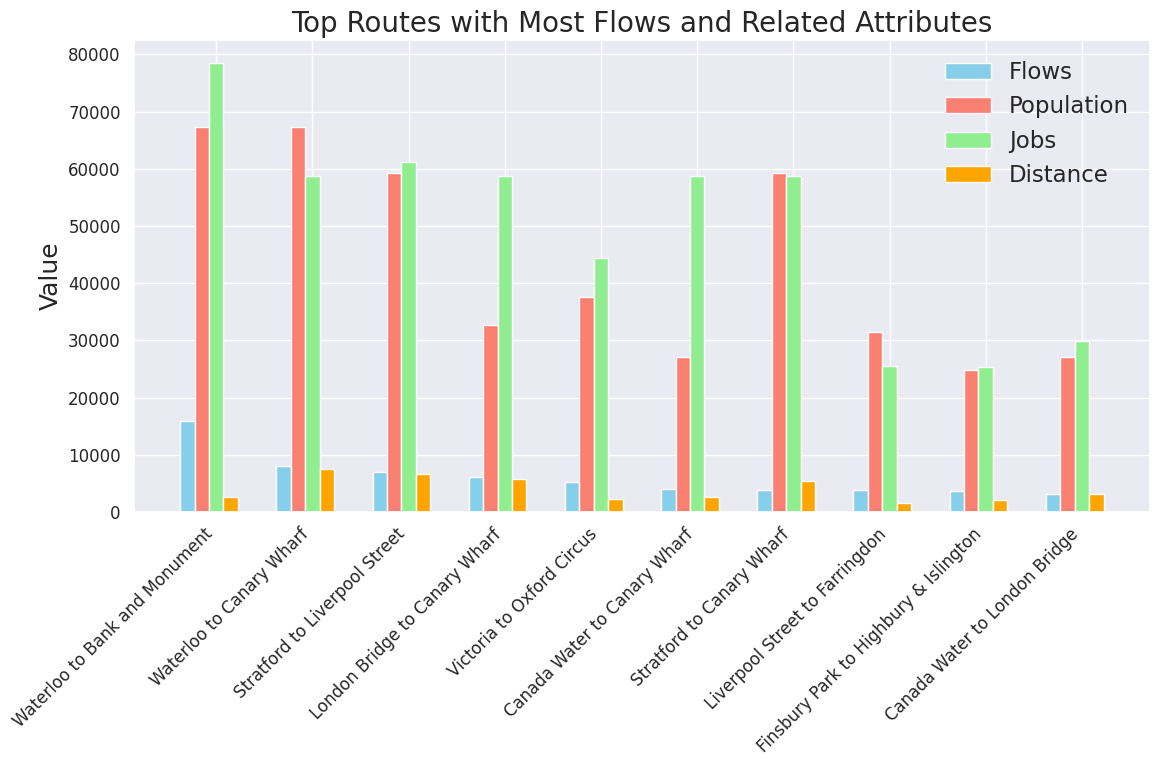

In [58]:
top_routes = df_original.nlargest(10, 'flows')

# Extracting necessary columns for plotting
routes = top_routes[['station_origin', 'station_destination']]
flows = top_routes['flows']
population = top_routes['population']
jobs = top_routes['jobs']
distance = top_routes['distance']

# Setting the positions for bars
ind = np.arange(len(routes))
width = 0.15  # width of each bar

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting bars for flows
p1 = ax.bar(ind - 2*width, flows, width, color='skyblue', label='Flows')

# Plotting bars for population, jobs, and distance
p2 = ax.bar(ind - width, population, width, color='salmon', label='Population')
p3 = ax.bar(ind, jobs, width, color='lightgreen', label='Jobs')
p4 = ax.bar(ind + width, distance, width, color='orange', label='Distance')

# Adding labels, title, and legend
ax.set_ylabel('Value')
ax.set_title('Top Routes with Most Flows and Related Attributes', fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(routes['station_origin'] + ' to ' + routes['station_destination'], rotation=45, ha='right')

plt.tight_layout()

# Adding labels, title, and legend
ax.set_ylabel('Value')
ax.set_title('Top Routes with Most Flows and Related Attributes', fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(routes['station_origin'] + ' to ' + routes['station_destination'], rotation=45, ha='right')

# Call legend to add legend based on labels provided in the plotting code
ax.legend()

# Increase font size in legends and ticks
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

# Save the figure as a PNG with DPI 300
plt.savefig('histograms.png', dpi=300)

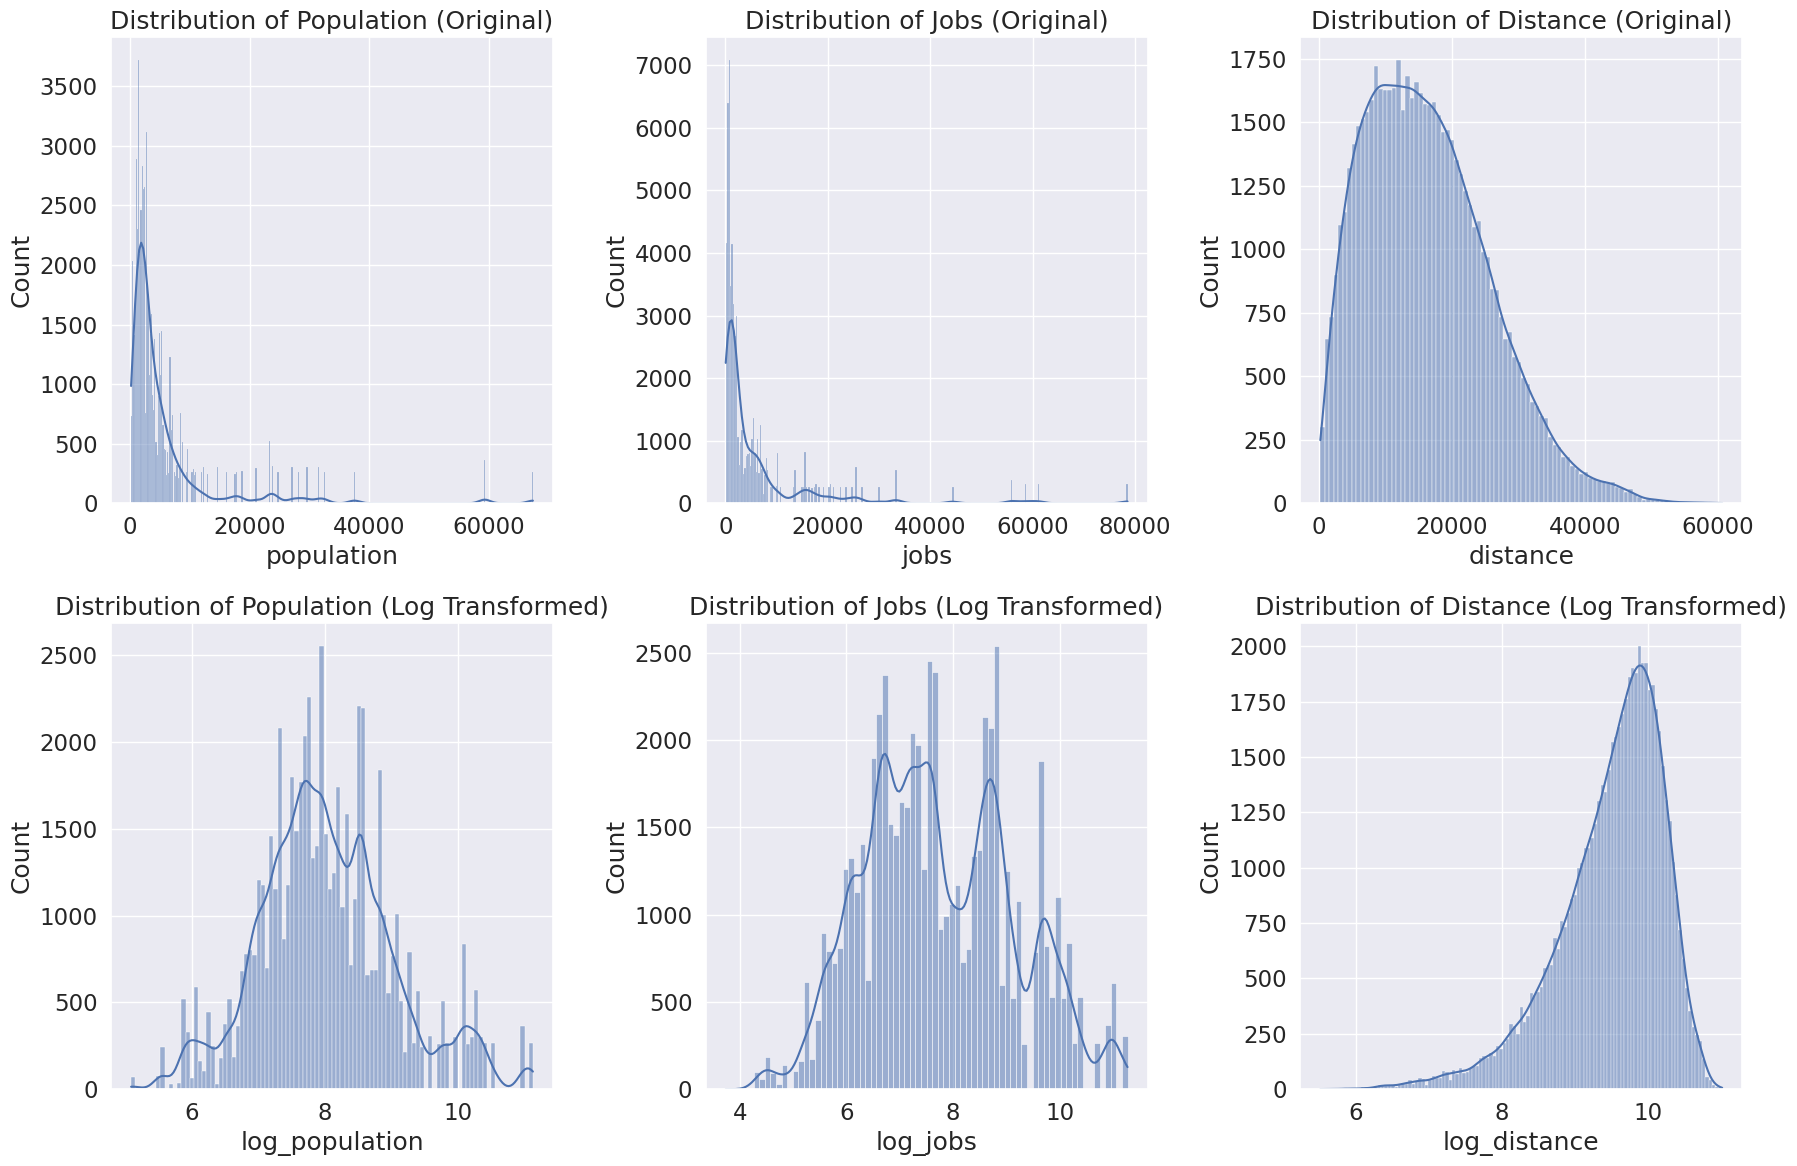

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1st row: original data
sns.histplot(data=df_original['population'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Population (Original)')
sns.histplot(data=df_original['jobs'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Jobs (Original)')
sns.histplot(data=df_original['distance'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Distance (Original)')

# Plot 2nd row: log-transformed data
sns.histplot(data=df_original['log_population'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Population (Log Transformed)')
sns.histplot(data=df_original['log_jobs'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Jobs (Log Transformed)')
sns.histplot(data=df_original['log_distance'], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Distance (Log Transformed)')

plt.tight_layout()
plt.show()

# Run Production-constrained model

## Poisson model

In [60]:
# code adapted from the practical
df = df_original
prodcons_formula = 'flows ~ station_origin + log_jobs + distance - 1' # better fit with exponential distance decay
prod_cons_pois = smf.glm(formula = prodcons_formula,data=df, family=sm.families.Poisson()).fit()
prod_cons_pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.1175e+05
Date:                Mon, 22 Apr 2024   Deviance:                   1.6164e+06
Time:                        20:33:29   Pearson chi2:                 2.38e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
station_origin[Abbey Road]                     -2.7541      0.041    -66.874      0.000      -2.835      -2.673
station_origin[Acton Central]                  -1.0560      0.029    -36.661      0.000      -1.112      -1.000
station_origin[Acton Town]                     -1.5131      0.017    -87.652      0.000      -1.547      -1.479
station_origin[Aldgate]                        -2.7606      0.019   -143.512      0.000      -2.798      -2.723
station_origin[Aldgate East]                   -2.6846      0.019   -144.878      0.000      -2.721      -2.648
station_origin[All Saints]                     -2.7165      0.037    -73.148      0.000      -2.789      -2.644
station_origin[Alperton]                       -1.5739      0.025    -62.243      0.000      -1.623      -1.524
station_origin[Amersham]                        1.0171      0.029     35.035      0.000       0.960       1.074
station_origin[Anerley]                        -0.9507      0.040    -23.955      0.000      -1.028      -0.873
station_origin[Angel]                          -2.4298      0.016   -147.869      0.000      -2.462      -2.398
station_origin[Archway]                        -1.5912      0.015   -109.483      0.000      -1.620      -1.563
station_origin[Arnos Grove]                    -1.3388      0.019    -70.078      0.000      -1.376      -1.301
station_origin[Arsenal]                        -2.7329      0.022   -123.759      0.000      -2.776      -2.690
station_origin[Baker Street]                   -1.8640      0.013   -143.803      0.000      -1.889      -1.839
station_origin[Balham]                         -0.7720      0.012    -65.105      0.000      -0.795      -0.749
station_origin[Bank and Monument]              -0.6085      0.008    -73.469      0.000      -0.625      -0.592
station_origin[Barbican]                       -3.5932      0.028   -129.615      0.000      -3.647      -3.539
station_origin[Barking]                        -0.4309      0.013    -34.101      0.000      -0.456      -0.406
station_origin[Barkingside]                    -1.3927      0.028    -49.364      0.000      -1.448      -1.337
station_origin[Barons Court]                   -2.0092      0.017   -120.657      0.000      -2.042      -1.977
station_origin[Bayswater]                      -3.0633      0.025   -120.764      0.000      -3.113      -3.014
station_origin[Beckton]                        -1.4005      0.030    -47.183      0.000      -1.459      -1.342
station_origin[Beckton Park]                   -3.0354      0.058    -52.290      0.000      -3.149      -2.922
station_origin[Becontree]                      -1.1978      0.021    -55.722      0.000      -1.240      -1.156
station_origin[Belsize Park]                   -2.4129     

In [61]:
O_i = pd.DataFrame(df.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
df = df.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(df.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
df = df.merge(D_j, on = "station_destination", how = "left" )

# pulling out the parameter values
coefs = pd.DataFrame(prod_cons_pois.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)

df = df.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
df.drop(columns = ["coef"], inplace = True)

alpha_i = prod_cons_pois.params[0:398]
gamma = prod_cons_pois.params[398]
beta = -prod_cons_pois.params[399]

df["flows_production_cons_pois_bau"] = np.exp(df["alpha_i"] + gamma*df["log_jobs"] - beta*df["distance"])
df["flows_production_cons_pois_bau"] = round(df["flows_production_cons_pois_bau"],0)

R-squared: 0.4653255483283663
RMSE: 96.638
My beta is 0.0001459080359155339
My gamma is 0.7366820332741049
Pearson Chi-square dispersion statistic: 39.00040840719599


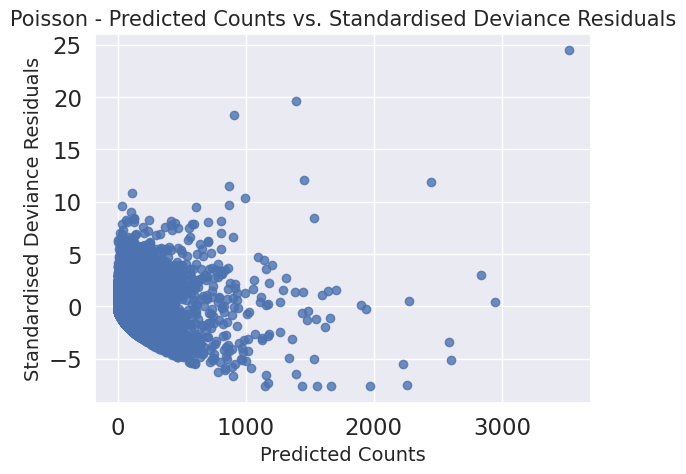

In [62]:
print(f'R-squared: {CalcRSqaured(df["flows"], df["flows_production_cons_pois_bau"])}')
print(f'RMSE: {CalcRMSE(df["flows"], df["flows_production_cons_pois_bau"])}')
print(f"My beta is {beta}")
print(f"My gamma is {gamma}")

pearson_chi2_dispersion = prod_cons_pois.pearson_chi2 / prod_cons_pois.df_resid
print("Pearson Chi-square dispersion statistic:", pearson_chi2_dispersion)

pois_std_dev_resid = prod_cons_pois.resid_deviance / np.sqrt(prod_cons_pois.pearson_chi2 / prod_cons_pois.df_resid)
pois_predicted_counts = df["flows_production_cons_pois_bau"]

plt.scatter(pois_predicted_counts, pois_std_dev_resid, alpha=0.8)
plt.xlabel('Predicted Counts', fontsize=14)
plt.ylabel('Standardised Deviance Residuals', fontsize=14)
plt.title('Poisson - Predicted Counts vs. Standardised Deviance Residuals', fontsize=15)
plt.grid(True)
plt.savefig('poisson.png', dpi=300)

plt.show()

In [63]:
# Flows matrix to check that the flow totals are retained
proncons_pois_mat = df.pivot_table(values ="flows_production_cons_pois_bau", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
proncons_pois_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,603.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1250.0
Acton Town,NaN,NaN,NaN,14.0,13.0,NaN,14.0,0.0,NaN,17.0,...,14.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3789.0
Aldgate,NaN,NaN,2.0,NaN,38.0,NaN,NaN,0.0,NaN,29.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2994.0
Aldgate East,NaN,NaN,2.0,41.0,NaN,NaN,0.0,0.0,NaN,30.0,...,3.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,42.0,52.0,NaN,NaN,NaN,NaN,31.0,...,3.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4895.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541.0
Woodside Park,NaN,NaN,2.0,20.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3114.0


In [64]:
# let's also check how many total flows are predicted
total_oroginalFlows = df['flows'].sum()
total_propndocs_flows = df['flows_production_cons_pois_bau'].sum()
diff_original_prondconstotalflows = total_oroginalFlows - total_propndocs_flows
percdiff_orginal_proncons = ((total_propndocs_flows - total_oroginalFlows) / total_oroginalFlows)*100

print(f"Origial total flows: {total_oroginalFlows}")
print(f"Production constrained total flows: {total_propndocs_flows}")
print(f"Difference between original and predicted total flows: {round(diff_original_prondconstotalflows,2)}")
print(f'''Percentage difference: {round(percdiff_orginal_proncons,5)}%
      ''')

Origial total flows: 1559751
Production constrained total flows: 1558869.0
Difference between original and predicted total flows: 882.0
Percentage difference: -0.05655%
      


In [65]:
df_prodcons = df

## Negative Binomial Model

In [66]:
# code adapted from the practical
prodcons_formula = 'flows ~ station_origin + log_jobs + distance - 1' # better fit without log
prod_cons_nb = smf.glm(formula = prodcons_formula,data=df, family=sm.families.NegativeBinomial()).fit()

# pulling out the parameter values
coefs = pd.DataFrame(prod_cons_nb.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i_nb", "index":"coef_nb"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef_nb"] = coefs["coef_nb"].str.replace(x, "",regex=True)

df = df.merge(coefs, left_on="station_origin", right_on="coef_nb", how = "left")
df.drop(columns = ["coef_nb"], inplace = True)

alpha_i_nb = prod_cons_nb.params[0:398]
gamma_nb = prod_cons_nb.params[398]
beta_nb = -prod_cons_nb.params[399]

df["flows_production_cons_nb_bau"] = np.exp(df["alpha_i_nb"] + gamma_nb*df["log_jobs"] - beta_nb*df["distance"])
df["flows_production_cons_nb_bau"] = round(df["flows_production_cons_nb_bau"],0)

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


R-squared: 0.3882059466810245
RMSE: 108.099
My beta is 0.0001459080359155339
My gamma is 0.7366820332741049
Pearson Chi-square dispersion statistic: 1.5365204262530798


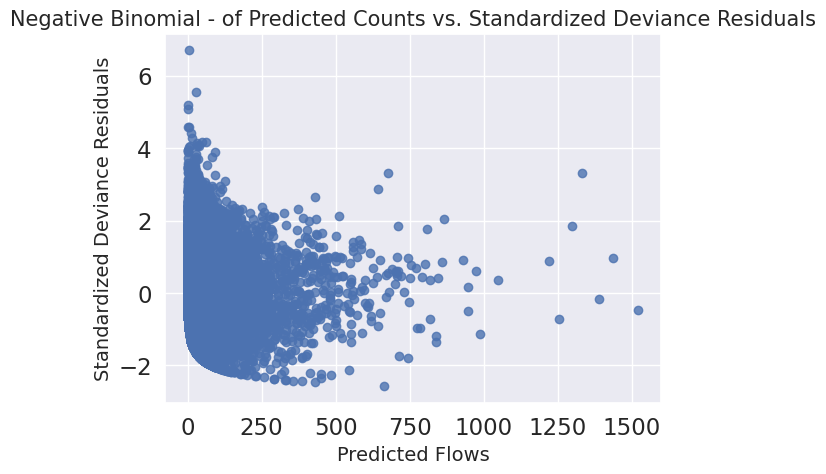

In [67]:
print(f'R-squared: {CalcRSqaured(df["flows"], df["flows_production_cons_nb_bau"])}')
print(f'RMSE: {CalcRMSE(df["flows"], df["flows_production_cons_nb_bau"])}')
print(f"My beta is {beta}")
print(f"My gamma is {gamma}")

pearson_chi2_dispersion = prod_cons_nb.pearson_chi2 / prod_cons_nb.df_resid
print("Pearson Chi-square dispersion statistic:", pearson_chi2_dispersion)

nb_std_dev_resid = prod_cons_nb.resid_deviance / np.sqrt(prod_cons_nb.pearson_chi2 / prod_cons_nb.df_resid)
nb_predicted_counts = df["flows_production_cons_nb_bau"]

plt.scatter(nb_predicted_counts, nb_std_dev_resid, alpha=0.8)
plt.xlabel('Predicted Flows', fontsize=14)
plt.ylabel('Standardized Deviance Residuals', fontsize=14)
plt.title('Negative Binomial - of Predicted Counts vs. Standardized Deviance Residuals', fontsize=15)
plt.savefig('negativebinomial.png', dpi=300)

plt.grid(True)
plt.show()

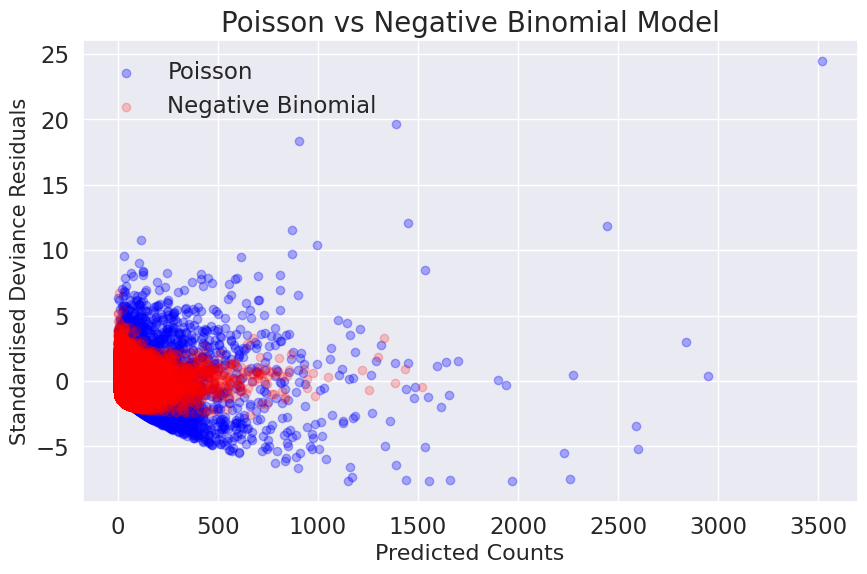

In [68]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot for Poisson
plt.scatter(pois_predicted_counts, pois_std_dev_resid, alpha=0.3, label='Poisson', color='blue')

# Plot for Negative Binomial
plt.scatter(nb_predicted_counts, nb_std_dev_resid, alpha=0.2, label='Negative Binomial', color='red')

# Set labels and title
plt.xlabel('Predicted Counts', fontsize=16)
plt.ylabel('Standardised Deviance Residuals', fontsize=15)
plt.title('Poisson vs Negative Binomial Model', fontsize=20)
plt.grid(True)

# Add legend
plt.legend()

# Save or show the plot
plt.savefig('combined_plot_modeldists.png', dpi=300)
plt.show()

In [69]:
df_prodcons = df
df_prodcons.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,O_i,D_j,alpha_i,flows_production_cons_pois_bau,alpha_i_nb,flows_production_cons_nb_bau
0,Abbey Road,Bank and Monument,1,599,78549,8131.525097,6.395262,11.271478,9.003504,603,78555,-2.754099,78.0,-1.975426,57.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,603,453,-2.754099,2.0,-1.975426,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,603,670,-2.754099,4.0,-1.975426,5.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,603,58781,-2.754099,99.0,-1.975426,65.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,603,15465,-2.754099,56.0,-1.975426,39.0


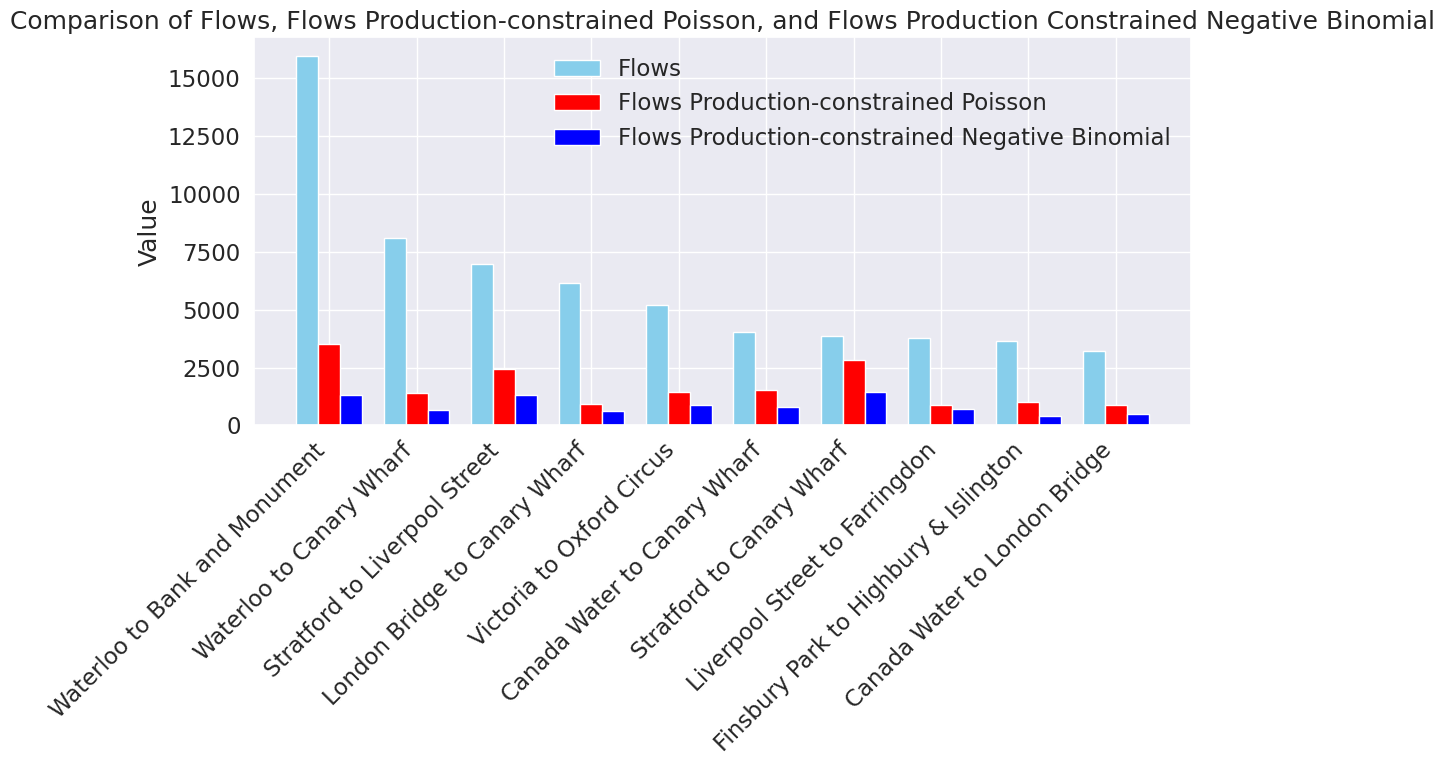

In [70]:
# Extracting necessary columns for plotting
top_routes = df_prodcons.nlargest(10, 'flows')

# Extracting necessary columns for plotting
routes = top_routes[['station_origin', 'station_destination']]
flows = top_routes['flows']
flows_production_cons_pois_bau = top_routes['flows_production_cons_pois_bau']  # New column added
flows_production_cons_nb_bau = top_routes['flows_production_cons_nb_bau']  # New column added

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Setting the positions for bars
ind = np.arange(len(routes))
width = 0.25  # width of each bar

# Plotting bars for flows, flows_production_cons_bau, and flows_production_cons_nb_bau
p1 = ax.bar(ind - width, flows, width, color='skyblue', label='Flows')
p2 = ax.bar(ind, flows_production_cons_pois_bau, width, color='red', label='Flows Production-constrained Poisson')
p3 = ax.bar(ind + width, flows_production_cons_nb_bau, width, color='blue', label='Flows Production-constrained Negative Binomial')

# Adding labels, title, and legend
ax.set_ylabel('Value')
ax.set_title('Comparison of Flows, Flows Production-constrained Poisson, and Flows Production Constrained Negative Binomial')
ax.set_xticks(ind)
ax.set_xticklabels(routes['station_origin'] + ' to ' + routes['station_destination'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('predicted_flows.png', dpi=300)

plt.show()

# Scenarios

## Scenario A
Canary Wharf has a 50% decrease in jobs

In [71]:
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf":
        val = 29386
    else:
        val = row["jobs"]
    return val
df_prodcons["jobs_scenarioA"] = df_prodcons.apply(new_jobs, axis=1)

In [72]:
# Recalibrate balancing factor
Dj_gamma = df_prodcons["jobs_scenarioA"]**gamma
dist_beta = np.exp(df_prodcons["distance"]*(-beta))
df_prodcons["Ai1"] = Dj_gamma * dist_beta
A_i = pd.DataFrame(df_prodcons.groupby(["station_origin"])["Ai1"].agg(np.sum))
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
df_prodcons = df_prodcons.merge(A_i, left_on="station_origin", right_index=True, how="left")

df_prodcons["scenarioA_flows"] = df_prodcons["A_i2"]*df_prodcons["O_i"]*Dj_gamma*dist_beta
df_prodcons["scenarioA_flows"] = round(df_prodcons["scenarioA_flows"])


In [73]:
# Adapt model predictions - replace 0s with 1s, to calculate percentage differences
df_prodcons['flows_production_cons_pois_bau'] = df_prodcons['flows_production_cons_pois_bau'].replace(0, 1)
df_prodcons['difference_ScenA'] = df_prodcons['scenarioA_flows'] - df_prodcons['flows_production_cons_pois_bau']
df_prodcons['percentage_difference_ScenA'] = ((df_prodcons['scenarioA_flows'] - df_prodcons['flows_production_cons_pois_bau']) / df_prodcons['flows_production_cons_pois_bau']) * 100

In [74]:
scenarioA_total_flows = df_prodcons['scenarioA_flows'].sum()
diff_original_ScenarioA_prondconstotalflows = total_oroginalFlows - scenarioA_total_flows
percdiff_orginal_scenarioAproncons = ((scenarioA_total_flows - total_oroginalFlows) / total_oroginalFlows)*100

print(f"Scenario A production constrained total flows: {scenarioA_total_flows}")
print(f"Difference between original and Scenario A predicted flows: {round(diff_original_ScenarioA_prondconstotalflows,2)}")
print(f"Percentage difference: {round(percdiff_orginal_scenarioAproncons,5)}%")

Scenario A production constrained total flows: 1558775.0
Difference between original and Scenario A predicted flows: 976.0
Percentage difference: -0.06257%


In [75]:
print(f'R-squared: {CalcRSqaured(df_prodcons["flows"], df_prodcons["scenarioA_flows"])}')
print(f'RMSE: {CalcRMSE(df_prodcons["flows"], df_prodcons["scenarioA_flows"])}')

R-squared: 0.44892708589830516
RMSE: 98.042


In [76]:
sorted_df = df_prodcons.sort_values(by='percentage_difference_ScenA', ascending=True)
top_5_stations = sorted_df.head(5)
for index, row in top_5_stations.iterrows():
    origin_destination = f"{row['station_origin']} to {row['station_destination']}"
    percentage_difference = row['percentage_difference_ScenA']
    print(f"{origin_destination}, Percentage Difference: {percentage_difference}")

Kingsbury to Dagenham East, Percentage Difference: -100.0
Canary Wharf to Theydon Bois, Percentage Difference: -100.0
Sudbury Hill to High Barnet, Percentage Difference: -100.0
Harrow-on-the-Hill to Hainault, Percentage Difference: -100.0
North Harrow to Gants Hill, Percentage Difference: -100.0


In [77]:
# Average difference in predicted flows
filtereddf_scenarioA = df_prodcons[df_prodcons["station_destination"] == "Canary Wharf"]
print(f"The change in flows to Canary Wharf: {np.mean(filtereddf_scenarioA['percentage_difference_ScenA'])}")
print(f"The change in flows globally: {np.mean(df_prodcons['percentage_difference_ScenA'])}")

The change in flows to Canary Wharf: -38.772100222353174
The change in flows globally: -12.118660664058297


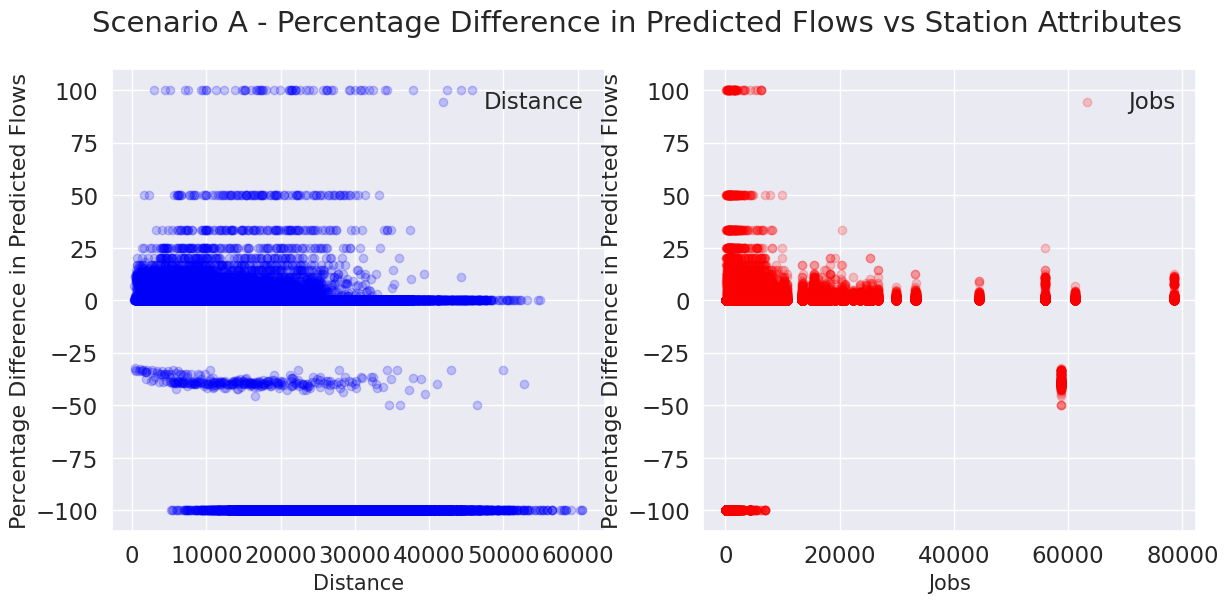

In [78]:
# df = sorted_df[sorted_df['percentage_difference'] != 0]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
axs[0].scatter(sorted_df['distance'], sorted_df['percentage_difference_ScenA'], color='blue', alpha=0.2, label='Distance')
axs[0].set_xlabel('Distance', fontsize=15)
axs[1].scatter(sorted_df['jobs'], sorted_df['percentage_difference_ScenA'], color='red', alpha=0.2, label='Jobs')
axs[1].set_xlabel('Jobs', fontsize=15)

# Common settings
for ax in axs:
    ax.set_ylabel('Percentage Difference in Predicted Flows', fontsize=16)
    ax.legend()

fig.suptitle('Scenario A - Percentage Difference in Predicted Flows vs Station Attributes', fontsize=21)

plt.savefig('scenarioAcomparison.png', dpi=300)
plt.show()

## Scenario B1 and B2

In [79]:
df_scenarioB = df_prodcons[['station_origin','station_destination','flows','population','jobs','distance','O_i','D_j','flows_production_cons_pois_bau','scenarioA_flows' ,'difference_ScenA','percentage_difference_ScenA']]

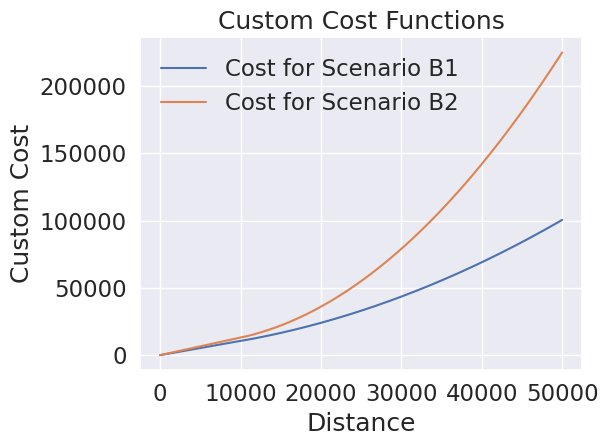

In [80]:
def custom_cost(distance, threshold, increase1, increase2):
    cost = distance * increase1
    threshold_mask = distance > threshold
    cost[threshold_mask] = (distance[threshold_mask] - threshold) * (increase2 * (distance[threshold_mask] - threshold) + increase1) + threshold * increase1
    return cost

distance_range = np.linspace(0, 50000, 5000)
cost_B1 = custom_cost(distance_range, 10000, 1.05, 0.00003)
cost_B2 = custom_cost(distance_range, 10000, 1.3, 0.0001)

plt.plot(distance_range, cost_B1, label='Cost for Scenario B1')
plt.plot(distance_range, cost_B2, label='Cost for Scenario B2')
plt.xlabel('Distance')
plt.ylabel('Custom Cost')
plt.title('Custom Cost Functions')
plt.legend()
plt.grid(True)

# Disable scientific notation for readability
plt.ticklabel_format(style='plain', axis='both')
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.tight_layout()

plt.savefig('custom_costs_funcs.png', dpi=300)
plt.show()

In [81]:
df_scenarioB['cost_B1'] = custom_cost(df_scenarioB['distance'], 10000, 1.05, 0.00003)
df_scenarioB['cost_B2'] = custom_cost(df_scenarioB['distance'], 10000, 1.3, 0.0001)

<ipython-input-81-6fc6b5afa9be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scenarioB['cost_B1'] = custom_cost(df_scenarioB['distance'], 10000, 1.05, 0.00003)
<ipython-input-81-6fc6b5afa9be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scenarioB['cost_B2'] = custom_cost(df_scenarioB['distance'], 10000, 1.3, 0.0001)


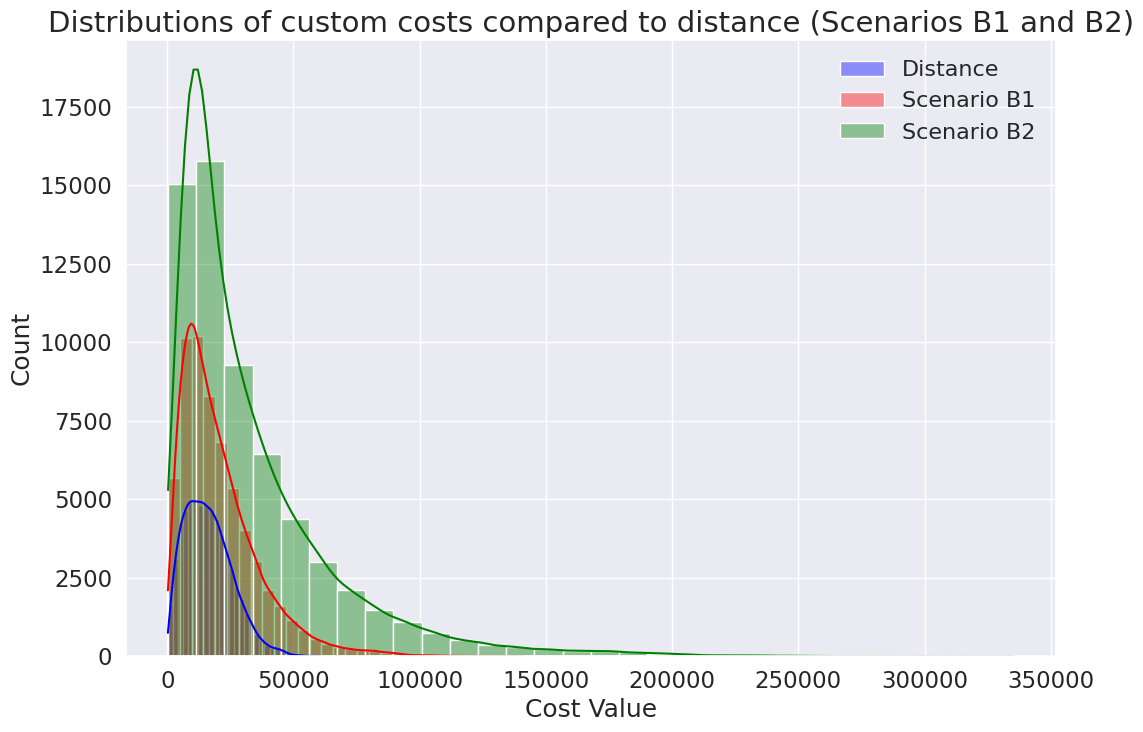

In [82]:
# Plot histograms of custom costs
plt.figure(figsize=(12, 8))
sns.histplot(df_scenarioB['distance'], bins=30, color='blue', alpha=0.4, label='Distance', kde=True)
sns.histplot(df_scenarioB['cost_B1'], bins=30, color='red', alpha=0.4, label='Scenario B1', kde=True)
sns.histplot(df_scenarioB['cost_B2'], bins=30, color='green', alpha=0.4, label='Scenario B2', kde=True)

# Set title and labels
plt.title('Distributions of custom costs compared to distance (Scenarios B1 and B2)', fontsize=21)
plt.xlabel('Cost Value', fontsize=18)
plt.ylabel('Count', fontsize=18)

# Set legend
plt.legend(fontsize=16)
plt.savefig('costs_comparison.png',dpi=300)
# Show plot
plt.show()

In [83]:
# Recalibrate balancing factor
Dj_gamma = df_scenarioB["jobs"]**gamma
costB1_beta = np.exp(df_scenarioB["cost_B1"]*(-beta))
costB2_beta = np.exp(df_scenarioB["cost_B2"]*(-beta))

df_scenarioB["Ai1_B1"] = Dj_gamma * costB1_beta
df_scenarioB["Ai1_B2"] = Dj_gamma * costB2_beta

A_i_B1 = pd.DataFrame(df_scenarioB.groupby(["station_origin"])["Ai1_B1"].agg(np.sum))
A_i_B2 = pd.DataFrame(df_scenarioB.groupby(["station_origin"])["Ai1_B2"].agg(np.sum))

A_i_B1["Ai1_B1"] = 1/A_i_B1["Ai1_B1"]
A_i_B2["Ai1_B2"] = 1/A_i_B2["Ai1_B2"]

A_i_B1.rename(columns={"Ai1_B1":"A_iB1"}, inplace=True)
A_i_B2.rename(columns={"Ai1_B2":"A_iB2"}, inplace=True)

df_scenarioB = df_scenarioB.merge(A_i_B1, left_on="station_origin", right_index=True, how="left")
df_scenarioB = df_scenarioB.merge(A_i_B2, left_on="station_origin", right_index=True, how="left")

df_scenarioB["scenarioB1_flows"] = df_scenarioB["A_iB1"]*df_scenarioB["O_i"]*Dj_gamma*costB1_beta
df_scenarioB["scenarioB1_flows"] = round(df_scenarioB["scenarioB1_flows"])

df_scenarioB["scenarioB2_flows"] = df_scenarioB["A_iB2"]*df_scenarioB["O_i"]*Dj_gamma*costB2_beta
df_scenarioB["scenarioB2_flows"] = round(df_scenarioB["scenarioB2_flows"])

df_scenarioB['percentage_difference_ScenB1'] = ((df_scenarioB['scenarioB1_flows'] - df_scenarioB['flows_production_cons_pois_bau']) / df_prodcons['flows_production_cons_pois_bau']) * 100
df_scenarioB['percentage_difference_ScenB2'] = ((df_scenarioB['scenarioB2_flows'] - df_scenarioB['flows_production_cons_pois_bau']) / df_prodcons['flows_production_cons_pois_bau']) * 100

df_scenarioB.head()

<ipython-input-83-5914c49c6678>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scenarioB["Ai1_B1"] = Dj_gamma * costB1_beta
<ipython-input-83-5914c49c6678>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scenarioB["Ai1_B2"] = Dj_gamma * costB2_beta


,station_origin,station_destination,flows,population,jobs,distance,O_i,D_j,flows_production_cons_pois_bau,scenarioA_flows,...,cost_B1,cost_B2,Ai1_B1,Ai1_B2,A_iB1,A_iB2,scenarioB1_flows,scenarioB2_flows,percentage_difference_ScenB1,percentage_difference_ScenB2
0,Abbey Road,Bank and Monument,1,599,78549,8131.525097,603,78555,78.0,84.0,...,8538.101352,10570.982626,1161.790546,863.595039,0.000109,0.000124,76.0,65.0,-2.564103,-16.666667
1,Abbey Road,Beckton,1,599,442,8510.121774,603,453,2.0,2.0,...,8935.627863,11063.158306,24.132962,17.692748,0.000109,0.000124,2.0,1.0,0.000000,-50.000000
2,Abbey Road,Blackwall,3,599,665,3775.448872,603,670,4.0,5.0,...,3964.221316,4908.083534,67.347419,58.682849,0.000109,0.000124,4.0,4.0,0.000000,0.000000
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,603,58781,99.0,63.0,...,5340.839931,6612.468486,1495.990728,1242.652064,0.000109,0.000124,98.0,93.0,-1.010101,-6.060606
4,Abbey Road,Canning Town,37,599,15428,2228.923167,603,15465,56.0,60.0,...,2340.369326,2897.600118,865.267004,797.700876,0.000109,0.000124,57.0,60.0,1.785714,7.142857


In [84]:
print(f'''
Scenario B1
R-squared: {CalcRSqaured(df_scenarioB["flows"], df_scenarioB["scenarioB1_flows"])}
RMSE: {CalcRMSE(df_scenarioB["flows"], df_scenarioB["scenarioB1_flows"])}
Average percentage difference: {df_scenarioB['percentage_difference_ScenB1'].mean()}
''')

print(f'''
Scenario B2
R-squared: {CalcRSqaured(df_scenarioB["flows"], df_scenarioB["scenarioB2_flows"])}
RMSE: {CalcRMSE(df_scenarioB["flows"], df_scenarioB["scenarioB2_flows"])}
Average percentage difference: {df_scenarioB['percentage_difference_ScenB2'].mean()}
''')


Scenario B1
R-squared: 0.4613319887488814
RMSE: 96.76
Average percentage difference: -27.41924001686467


Scenario B2
R-squared: 0.44369597586546444
RMSE: 98.025
Average percentage difference: -41.328356757624626



In [85]:
df_scenarioB["scenarioB2_flows"].value_counts()

scenarioB2_flows
0.0       20502
1.0        5971
2.0        3309
3.0        2498
4.0        1917
          ...  
995.0         1
850.0         1
1205.0        1
744.0         1
1278.0        1
Name: count, Length: 747, dtype: int64

## Analyis of the 3 Scenarios

In [86]:
df_scenarios = df_scenarioB[['station_origin','station_destination','flows','population','jobs','distance','flows_production_cons_pois_bau','scenarioA_flows','scenarioB1_flows','scenarioB2_flows','percentage_difference_ScenA','percentage_difference_ScenB1','percentage_difference_ScenB2']]
df_scenarios.head(2)

,station_origin,station_destination,flows,population,jobs,distance,flows_production_cons_pois_bau,scenarioA_flows,scenarioB1_flows,scenarioB2_flows,percentage_difference_ScenA,percentage_difference_ScenB1,percentage_difference_ScenB2
0,Abbey Road,Bank and Monument,1,599,78549,8131.525097,78.0,84.0,76.0,65.0,7.692308,-2.564103,-16.666667
1,Abbey Road,Beckton,1,599,442,8510.121774,2.0,2.0,2.0,1.0,0.000000,0.000000,-50.000000


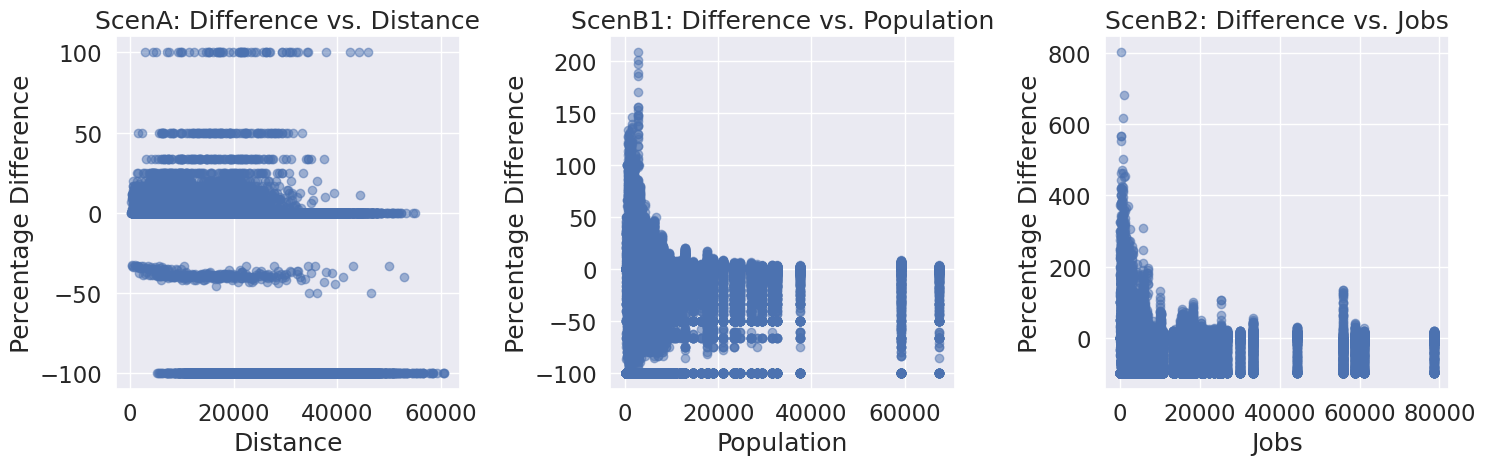

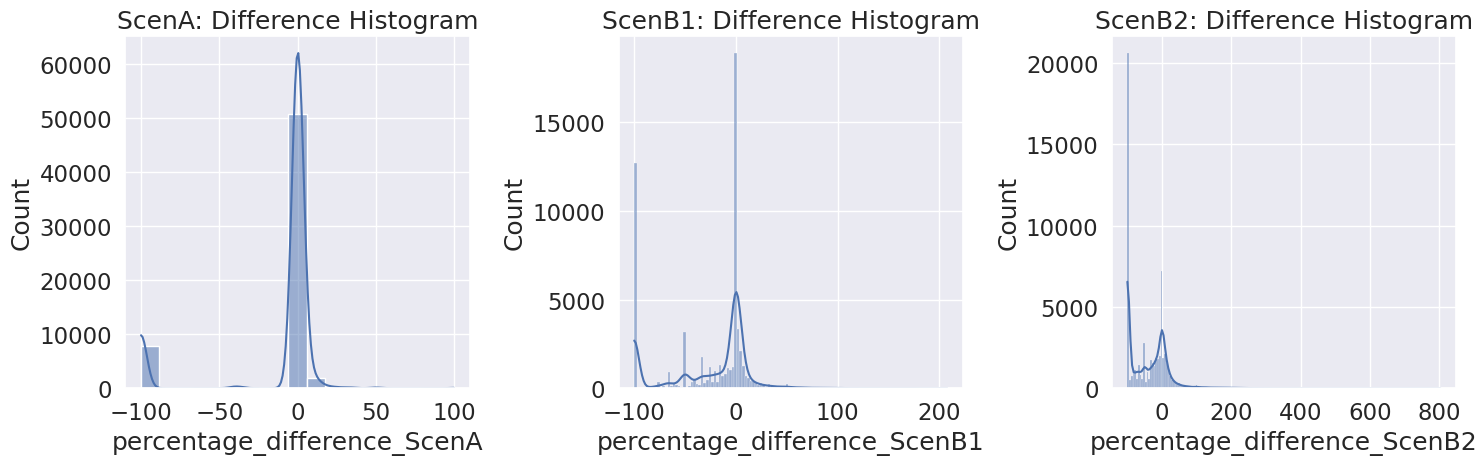

In [87]:
plt.figure(figsize=(15, 5))

# Scatter plot for 'percentage_difference_ScenA'
plt.subplot(1, 3, 1)
plt.scatter(df_scenarios['distance'], df_scenarios['percentage_difference_ScenA'], alpha=0.5)
plt.title('ScenA: Difference vs. Distance')
plt.xlabel('Distance')
plt.ylabel('Percentage Difference')

# Scatter plot for 'percentage_difference_ScenB1'
plt.subplot(1, 3, 2)
plt.scatter(df_scenarios['population'], df_scenarios['percentage_difference_ScenB1'], alpha=0.5)
plt.title('ScenB1: Difference vs. Population')
plt.xlabel('Population')
plt.ylabel('Percentage Difference')

# Scatter plot for 'percentage_difference_ScenB2'
plt.subplot(1, 3, 3)
plt.scatter(df_scenarios['jobs'], df_scenarios['percentage_difference_ScenB2'], alpha=0.5)
plt.title('ScenB2: Difference vs. Jobs')
plt.xlabel('Jobs')
plt.ylabel('Percentage Difference')

plt.tight_layout()
plt.show()

# Histograms
plt.figure(figsize=(15, 5))

# Histogram for 'percentage_difference_ScenA'
plt.subplot(1, 3, 1)
sns.histplot(df_scenarios['percentage_difference_ScenA'], kde=True)
plt.title('ScenA: Difference Histogram')

# Histogram for 'percentage_difference_ScenB1'
plt.subplot(1, 3, 2)
sns.histplot(df_scenarios['percentage_difference_ScenB1'], kde=True)
plt.title('ScenB1: Difference Histogram')

# Histogram for 'percentage_difference_ScenB2'
plt.subplot(1, 3, 3)
sns.histplot(df_scenarios['percentage_difference_ScenB2'], kde=True)
plt.title('ScenB2: Difference Histogram')

plt.tight_layout()
plt.show()

In [88]:
df_normalized = df_scenarios[['percentage_difference_ScenA',
                               'percentage_difference_ScenB1',
                               'percentage_difference_ScenB2']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

<ipython-input-89-5a68f991af87>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


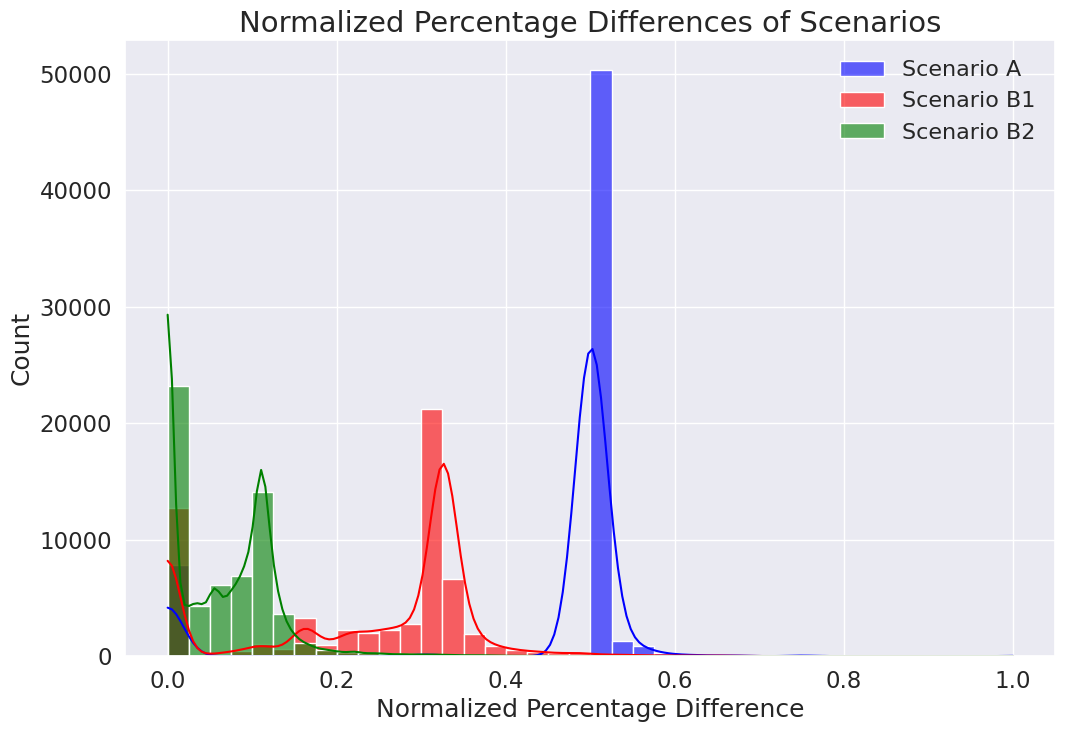

In [89]:
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.5)

# Plot histograms
plt.figure(figsize=(12, 8))
sns.histplot(df_normalized['percentage_difference_ScenA'], bins=40, color='blue', alpha=0.6, label='Scenario A', kde=True)
sns.histplot(df_normalized['percentage_difference_ScenB1'], bins=40, color='red', alpha=0.6, label='Scenario B1', kde=True)
sns.histplot(df_normalized['percentage_difference_ScenB2'], bins=40, color='green', alpha=0.6, label='Scenario B2', kde=True)

# Set title and labels
plt.title('Normalized Percentage Differences of Scenarios', fontsize=21)
plt.xlabel('Normalized Percentage Difference', fontsize=18)
plt.ylabel('Count', fontsize=18)

# Set legend
plt.legend(fontsize=16)
plt.savefig('3scenarios_hist.png', dpi=300)
# Show plot
plt.show()

<ipython-input-101-83be476561b3>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


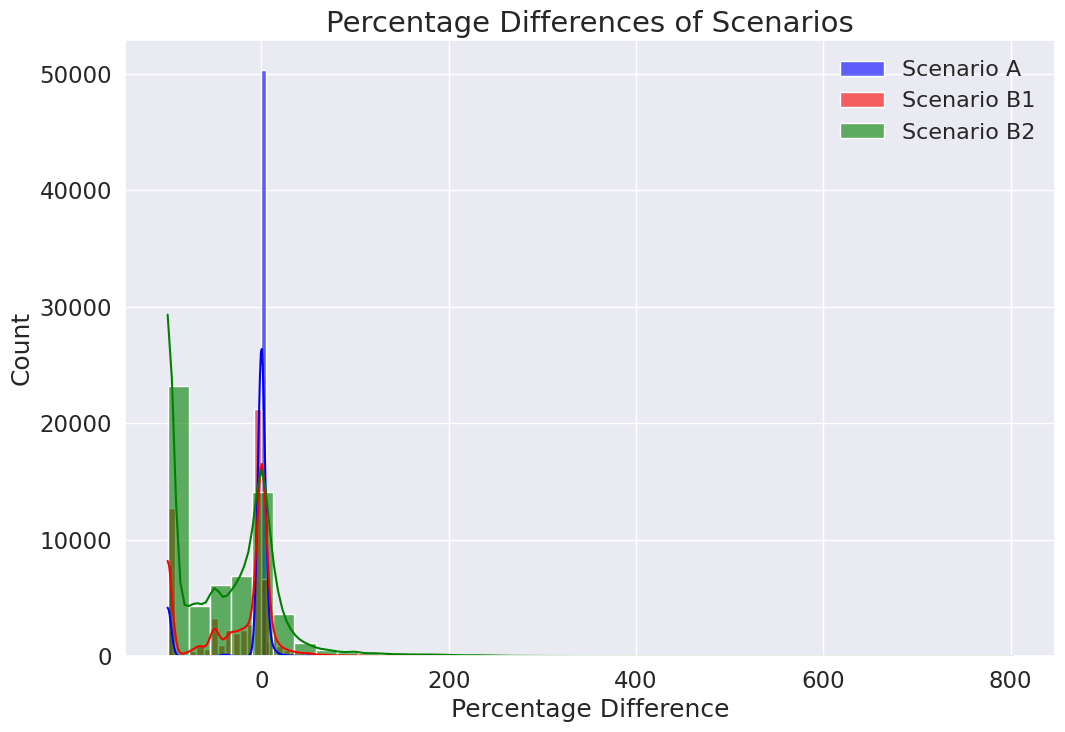

In [101]:
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.5)

# Plot histograms
plt.figure(figsize=(12, 8))
sns.histplot(df_scenarios['percentage_difference_ScenA'], bins=40, color='blue', alpha=0.6, label='Scenario A', kde=True)
sns.histplot(df_scenarios['percentage_difference_ScenB1'], bins=40, color='red', alpha=0.6, label='Scenario B1', kde=True)
sns.histplot(df_scenarios['percentage_difference_ScenB2'], bins=40, color='green', alpha=0.6, label='Scenario B2', kde=True)

# Set title and labels
plt.title('Percentage Differences of Scenarios', fontsize=21)
plt.xlabel('Percentage Difference', fontsize=18)
plt.ylabel('Count', fontsize=18)

# Set legend
plt.legend(fontsize=16)
plt.savefig('3scenarios_hist.png', dpi=300)
# Show plot
plt.show()

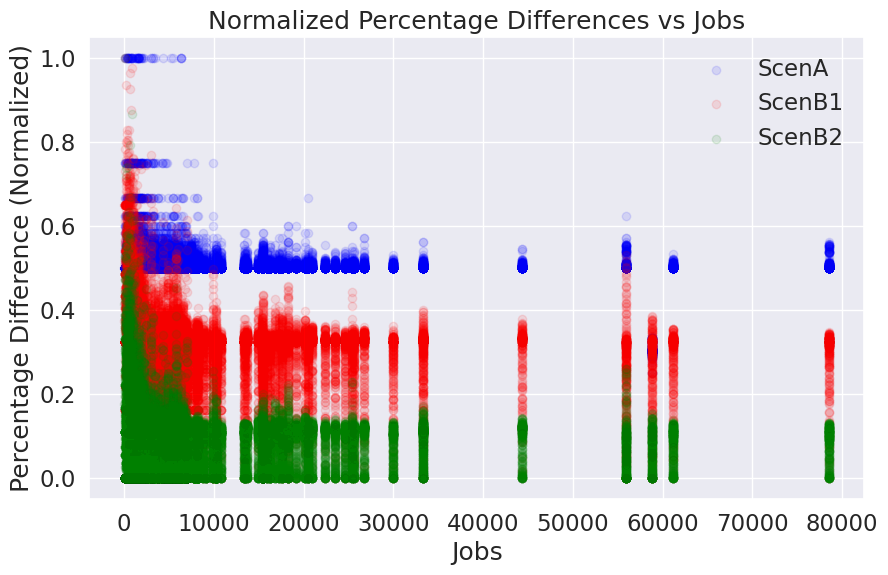

In [91]:
plt.figure(figsize=(10, 6))
plt.scatter(df_scenarios['jobs'], df_normalized['percentage_difference_ScenA'], color='blue', alpha=0.1, label='ScenA')
plt.scatter(df_scenarios['jobs'], df_normalized['percentage_difference_ScenB1'], color='red', alpha=0.1, label='ScenB1')
plt.scatter(df_scenarios['jobs'], df_normalized['percentage_difference_ScenB2'], color='green', alpha=0.1, label='ScenB2')

plt.title('Normalized Percentage Differences vs Jobs')
plt.xlabel('Jobs')
plt.ylabel('Percentage Difference (Normalized)')
plt.legend()
plt.show()

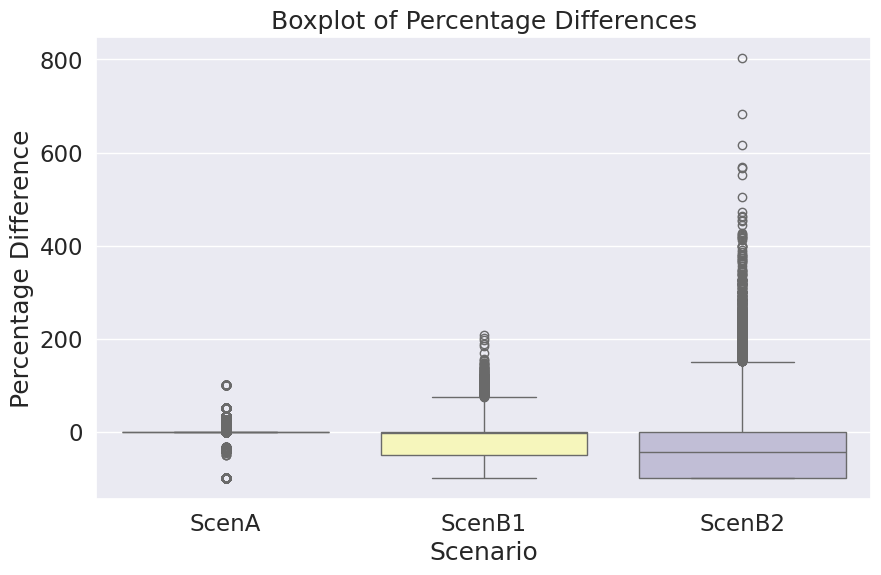

In [92]:
# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_scenarios[['percentage_difference_ScenA',
                                'percentage_difference_ScenB1',
                                'percentage_difference_ScenB2']],
            palette="Set3")
plt.title('Boxplot of Percentage Differences')
plt.ylabel('Percentage Difference')
plt.xlabel('Scenario')
plt.xticks(ticks=[0, 1, 2], labels=['ScenA', 'ScenB1', 'ScenB2'])
plt.show()

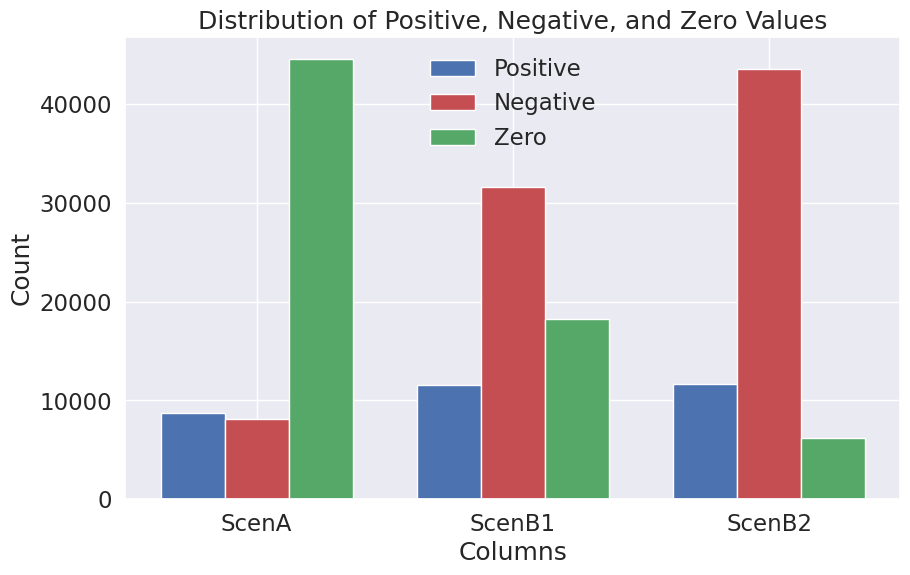

In [93]:
positive_counts = (df_scenarios[['percentage_difference_ScenA',
                                 'percentage_difference_ScenB1',
                                 'percentage_difference_ScenB2']] > 0).sum()
negative_counts = (df_scenarios[['percentage_difference_ScenA',
                                 'percentage_difference_ScenB1',
                                 'percentage_difference_ScenB2']] < 0).sum()
zero_counts = (df_scenarios[['percentage_difference_ScenA',
                             'percentage_difference_ScenB1',
                             'percentage_difference_ScenB2']] == 0).sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(positive_counts))

plt.bar(index, positive_counts, bar_width, label='Positive', color='b')
plt.bar([i + bar_width for i in index], negative_counts, bar_width, label='Negative', color='r')
plt.bar([i + 2 * bar_width for i in index], zero_counts, bar_width, label='Zero', color='g')

plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Distribution of Positive, Negative, and Zero Values')
plt.xticks([i + bar_width for i in index], ['ScenA', 'ScenB1', 'ScenB2'])
plt.legend()
plt.show()

In [94]:
# Calculate summary statistics
summary_stats = df_scenarios[['percentage_difference_ScenA',
                              'percentage_difference_ScenB1',
                              'percentage_difference_ScenB2']].describe()

# Calculate variance
variance = df_scenarios[['percentage_difference_ScenA',
                         'percentage_difference_ScenB1',
                         'percentage_difference_ScenB2']].var()

# Round to 3 decimal points
summary_stats = summary_stats.round(2)
variance = variance.round(2)

# Add variance column
summary_stats.loc['variance'] = variance

# Add range column
summary_stats.loc['range'] = summary_stats.loc['max'] - summary_stats.loc['min']

# Rename index to make it more descriptive
summary_stats.rename(index={'mean': 'Mean',
                            'std': 'Standard Deviation',
                            'min': 'Minimum',
                            '25%': '25th Percentile',
                            '50%': 'Median',
                            '75%': '75th Percentile',
                            'max': 'Maximum'}, inplace=True)

summary_stats

,percentage_difference_ScenA,percentage_difference_ScenB1,percentage_difference_ScenB2
count,61413.00,61413.00,61413.00
Mean,-12.12,-27.42,-41.33
Standard Deviation,34.11,43.16,58.43
Minimum,-100.00,-100.00,-100.00
25th Percentile,0.00,-50.00,-100.00
Median,0.00,-2.70,-44.44
75th Percentile,0.00,0.00,0.00
Maximum,100.00,207.89,802.63
variance,1163.27,1862.48,3414.33
range,200.00,307.89,902.63
